<a href="https://colab.research.google.com/github/Yasir323/100-days-of-code/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Convolutional Layers

The most important building block of a CNN is the convolutional
layer: neurons in the first convolutional layer are not connected to
every single pixel in the input image (like they were in the layers
discussed in previous chapters), but only to pixels in their receptive fields (see Figure 14-2). In turn, each neuron in the second
convolutional layer is connected only to neurons located within a
small rectangle in the first layer. This architecture allows the
network to concentrate on small low-level features in the first
hidden layer, then assemble them into larger higher-level features in
the next hidden layer, and so on. This hierarchical structure is
common in real-world images, which is one of the reasons why
CNNs work so well for image recognition.

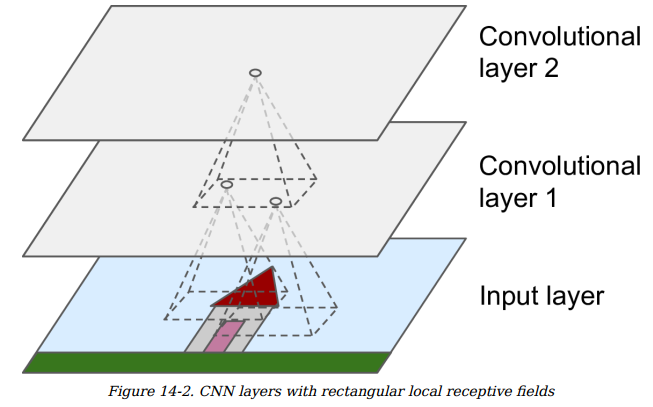

A neuron located in row i, column j of a given layer is connected to
the outputs of the neurons in the previous layer located in rows i to i
+ f – 1, columns j to j + f – 1, where f and f are the height and
width of the receptive field (see Figure 14-3). In order for a layer to
have the same height and width as the previous layer, it is common to add zeros around the inputs, as shown in the diagram. This is
called zero padding.

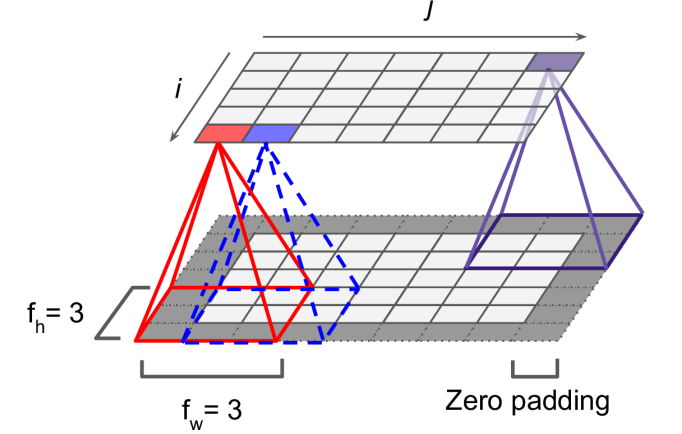

It is also possible to connect a large input layer to a much smaller
layer by spacing out the receptive fields, as shown in Figure 14-4.
This dramatically reduces the model’s computational complexity.
The shift from one receptive field to the next is called the stride.

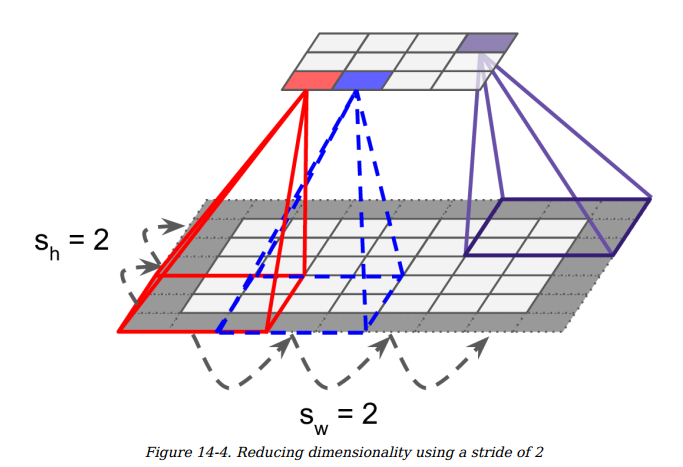

### Filters
A neuron’s weights can be represented as a small image the size of
the receptive field. For example, Figure 14-5 shows two possible
sets of weights, called filters (or convolution kernels).

Thus, a layer full of neurons using the same filter outputs a feature
map, which highlights the areas in an image that activate the filter
the most.

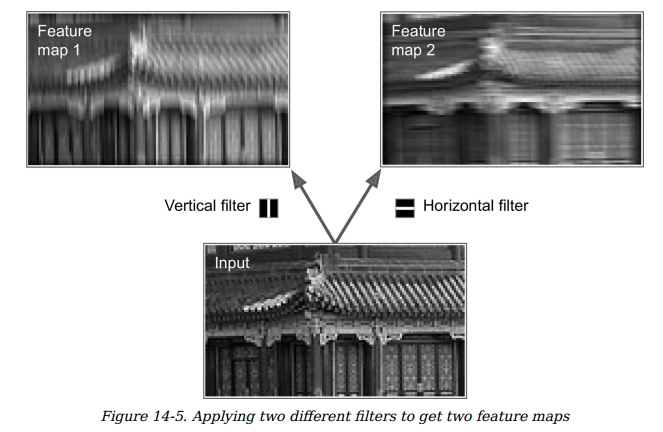

### Stacking Multiple Feature Maps
Up to now, for simplicity, I have represented the output of each
convolutional layer as a 2D layer, but in reality a convolutional layer
has multiple filters (you decide how many) and outputs one feature
map per filter, so it is more accurately represented in 3D (see
Figure 14-6). It has one neuron per pixel in each feature map, and
all neurons within a given feature map share the same parameters
(i.e., the same weights and bias term). Neurons in different feature
maps use different parameters. A neuron’s receptive field is the
same as described earlier, but it extends across all the previous
layers’ feature maps. In short, a convolutional layer simultaneously applies multiple trainable filters to its inputs, making it capable of
detecting multiple features anywhere in its inputs.

*The fact that all neurons in a feature map share the same parameters
dramatically reduces the number of parameters in the model. Once the CNN has
learned to recognize a pattern in one location, it can recognize it in any other
location. In contrast, once a regular DNN has learned to recognize a pattern in
one location, it can recognize it only in that particular location.*

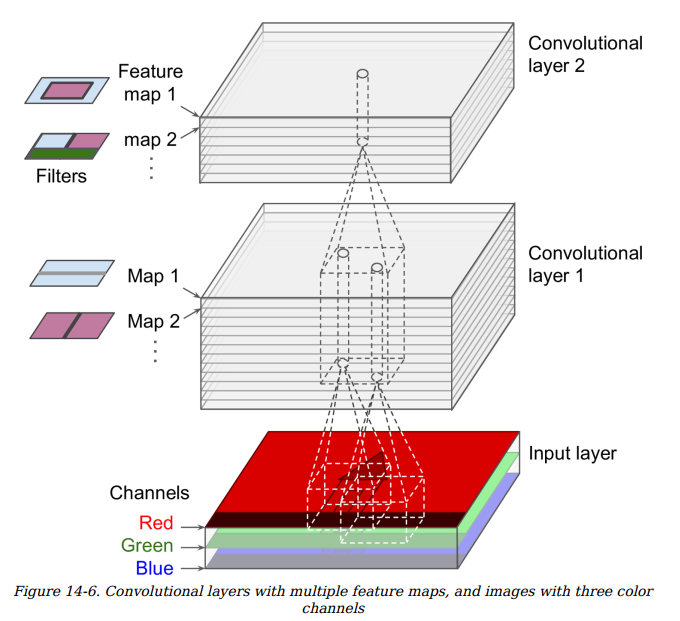

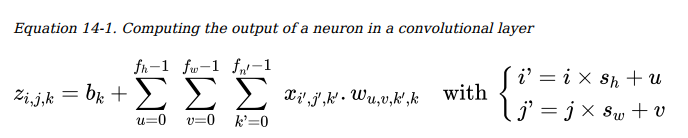

In TensorFlow, each input image is typically represented as a 3D
tensor of shape [height, width, channels]. A mini-batch is
represented as a 4D tensor of shape [mini-batch size, height, width,
channels]. The weights of a convolutional layer are represented as a
4D tensor of shape [fh , fw, fn`, fn]. The bias terms of a convolutional
layer are simply represented as a 1D tensor of shape [fn].

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

In [3]:
from sklearn.datasets import load_sample_image

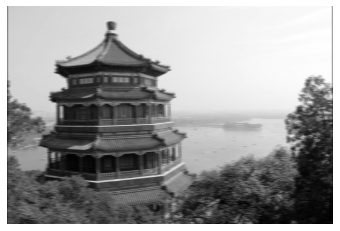

In [4]:
# Load sample image
china = load_sample_image('china.jpg') / 255
flower = load_sample_image('flower.jpg') / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off") # Not shown in the book
plt.show()

**Padding** must be either "same" or "valid":
If set to "same", the convolutional layer uses zero
padding if necessary. The output size is set to the
number of input neurons divided by the stride,
rounded up. For example, if the input size is 13 and
the stride is 5 (see Figure 14-7), then the output size
is 3 (i.e., 13 / 5 = 2.6, rounded up to 3). Then zeros are
added as evenly as possible around the inputs, as
needed. When strides=1, the layer’s outputs will have
the same spatial dimensions (width and height) as its
inputs, hence the name same.
If set to "valid", the convolutional layer does not use
zero padding and may ignore some rows and columns
at the bottom and right of the input image, depending
on the stride, as shown in Figure 14-7 (for simplicity,
only the horizontal dimension is shown here, but of
course the same logic applies to the vertical
dimension). This means that every neuron’s receptive
field lies strictly within valid positions inside the input
(it does not go out of bounds), hence the name valid.

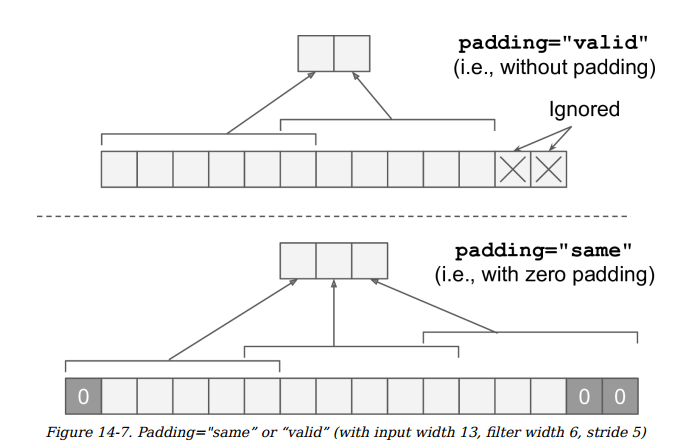

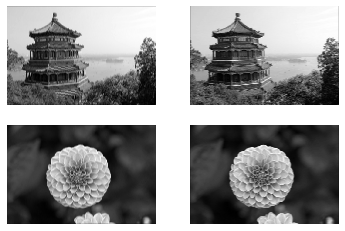

In [5]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

In [6]:
def crop(images):
    return images[150:220, 130:250]

Saving figure china_original


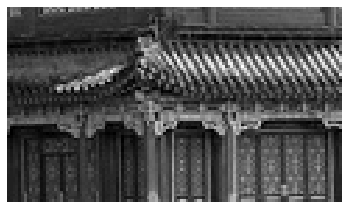

Saving figure china_vertical


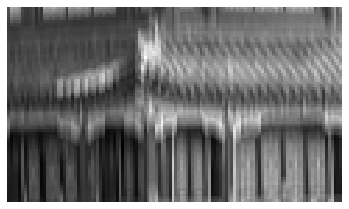

Saving figure china_horizontal


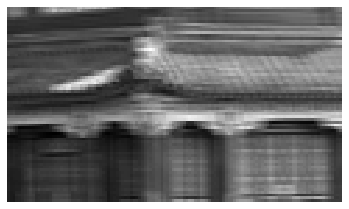

In [7]:
plot_image(crop(images[0, :, :, 0]))
save_fig("china_original", tight_layout=False)
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    save_fig(filename, tight_layout=False)
    plt.show()

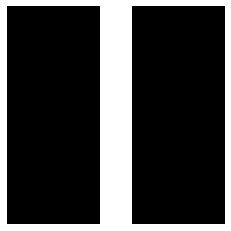

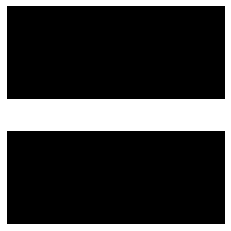

In [8]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

In [9]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                           padding="SAME", activation="relu")

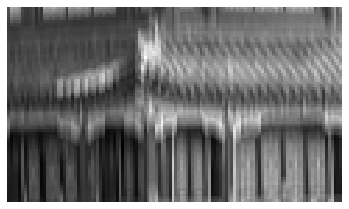

In [10]:
plot_image(crop(outputs[0, :, :, 0]))
plt.show()

### Valid vs Same Padding

In [11]:
def feature_map_size(input_size, kernel_size, strides=1, padding="SAME"):
    if padding == "SAME":
        return (input_size - 1) // strides + 1
    else:
        return (input_size - kernel_size) // strides + 1

In [12]:
def pad_before_and_padded_size(input_size, kernel_size, strides=1):
    fmap_size = feature_map_size(input_size, kernel_size, strides)
    padded_size = max((fmap_size - 1) * strides + kernel_size, input_size)
    pad_before = (padded_size - input_size) // 2
    return pad_before, padded_size

In [13]:
def manual_same_padding(images, kernel_size, strides=1):
    if kernel_size == 1:
        return images.astype(np.float32)
    batch_size, height, width, channels = images.shape
    top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width  = pad_before_and_padded_size(width, kernel_size, strides)
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_images = np.zeros(padded_shape, dtype=np.float32)
    padded_images[:, top_pad:height+top_pad, left_pad:width+left_pad, :] = images
    return padded_images

Using "SAME" padding is equivalent to padding manually using manual_same_padding() then using "VALID" padding (confusingly, "VALID" padding means no padding at all):

In [14]:
kernel_size = 7
strides = 2

conv_valid = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="VALID")
conv_same = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="SAME")

valid_output = conv_valid(manual_same_padding(images, kernel_size, strides))

# Need to call build() so conv_same's weights get created
conv_same.build(tf.TensorShape(images.shape))

# Copy the weights from conv_valid to conv_same
conv_same.set_weights(conv_valid.get_weights())

same_output = conv_same(images.astype(np.float32))

assert np.allclose(valid_output.numpy(), same_output.numpy())

### Memory Requirements
Another problem with CNNs is that the convolutional layers require
a huge amount of RAM. This is especially true during training, because the reverse pass of backpropagation requires all the
intermediate values computed during the forward pass.
For example, consider a convolutional layer with 5 × 5 filters,
outputting 200 feature maps of size 150 × 100, with stride 1 and
"same" padding. If the input is a 150 × 100 RGB image (three
channels), then the number of parameters is (5 × 5 × 3 + 1) × 200
= 15,200 (the + 1 corresponds to the bias terms), which is fairly
small compared to a fully connected layer. However, each of the
200 feature maps contains 150 × 100 neurons, and each of these
neurons needs to compute a weighted sum of its 5 × 5 × 3 = 75
inputs: that’s a total of 225 million float multiplications. Not as bad
as a fully connected layer, but still quite computationally intensive.
Moreover, if the feature maps are represented using 32-bit floats,
then the convolutional layer’s output will occupy 200 × 150 × 100 ×
32 = 96 million bits (12 MB) of RAM. And that’s just for one
instance—if a training batch contains 100 instances, then this layer
will use up 1.2 GB of RAM!

During inference (i.e., when making a prediction for a new instance)
the RAM occupied by one layer can be released as soon as the next
layer has been computed, so you only need as much RAM as
required by two consecutive layers. But during training everything
computed during the forward pass needs to be preserved for the
reverse pass, so the amount of RAM needed is (at least) the total
amount of RAM required by all layers.

*If training crashes because of an out-of-memory error, you can try reducing the
mini-batch size. Alternatively, you can try reducing dimensionality using a stride,
or removing a few layers. Or you can try using 16-bit floats instead of 32-bit
floats. Or you could distribute the CNN across multiple devices.*

## Pooling Layer
Once you understand how convolutional layers work, the pooling
layers are quite easy to grasp. Their goal is to subsample (i.e.,
shrink) the input image in order to reduce the computational load,
the memory usage, and the number of parameters (thereby limiting
the risk of overfitting).
Just like in convolutional layers, each neuron in a pooling layer is
connected to the outputs of a limited number of neurons in the
previous layer, located within a small rectangular receptive field.
You must define its size, the stride, and the padding type, just like
before. However, a pooling neuron has no weights; all it does is
aggregate the inputs using an aggregation function such as the max
or mean. 

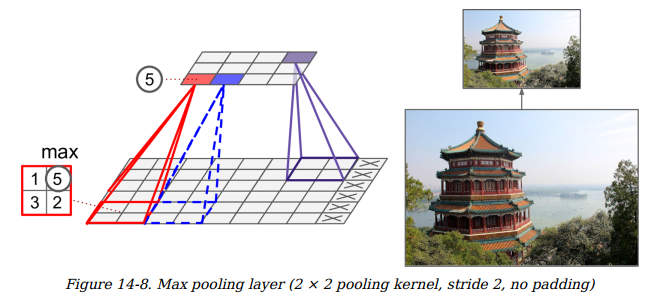

*A pooling layer typically works on every input channel independently, so the
output depth is the same as the input depth.*

Other than reducing computations, memory usage, and the number
of parameters, a max pooling layer also introduces some level of
invariance to small translations, as shown in Figure 14-9. Here we
assume that the bright pixels have a lower value than dark pixels,
and we consider three images (A, B, C) going through a max pooling
layer with a 2 × 2 kernel and stride 2. Images B and C are the same
as image A, but shifted by one and two pixels to the right. As you
can see, the outputs of the max pooling layer for images A and B are
identical. This is what translation invariance means. For image C,
the output is different: it is shifted one pixel to the right (but there
is still 75% invariance). By inserting a max pooling layer every few
layers in a CNN, it is possible to get some level of translation
invariance at a larger scale. Moreover, max pooling offers a small
amount of rotational invariance and a slight scale invariance. Such
invariance (even if it is limited) can be useful in cases where the
prediction should not depend on these details, such as in
classification tasks.

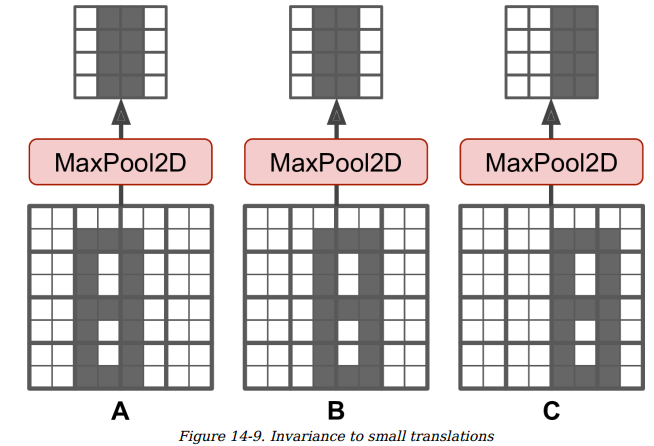

However, max pooling has some downsides too. Firstly, it is
obviously very destructive: even with a tiny 2 × 2 kernel and a stride of 2, the output will be two times smaller in both directions
(so its area will be four times smaller), simply dropping 75% of the
input values. And in some applications, invariance is not desirable.
Take semantic segmentation (the task of classifying each pixel in an
image according to the object that pixel belongs to, which we’ll
explore later in this chapter): obviously, if the input image is
translated by one pixel to the right, the output should also be
translated by one pixel to the right. The goal in this case is
equivariance, not invariance: a small change to the inputs should
lead to a corresponding small change in the output.

In [15]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

Note that max pooling and average pooling can be performed along
the depth dimension rather than the spatial dimensions, although
this is not as common. This can allow the CNN to learn to be
invariant to various features. For example, it could learn multiple
filters, each detecting a different rotation of the same pattern (such
as hand-written digits; see Figure 14-10), and the depthwise max
pooling layer would ensure that the output is the same regardless of the rotation. The CNN could similarly learn to be invariant to
anything else: thickness, brightness, skew, color, and so on.

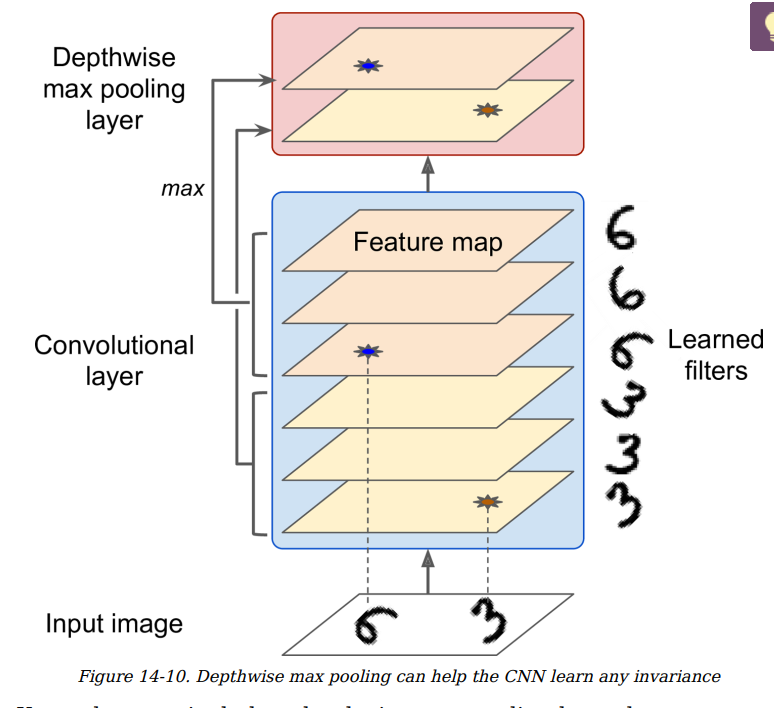

Keras does not include a depthwise max pooling layer, but
TensorFlow’s low-level Deep Learning API does: just use the
tf.nn.max_pool() function, and specify the kernel size and strides as
4-tuples (i.e., tuples of size 4). The first three values of each should
be 1: this indicates that the kernel size and stride along the batch,
height, and width dimensions should be 1. The last value should be
whatever kernel size and stride you want along the depth dimension
—for example, 3 (this must be a divisor of the input depth; it will not
work if the previous layer outputs 20 feature maps, since 20 is not a
multiple of 3):

In [16]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

Saving figure china_max_pooling


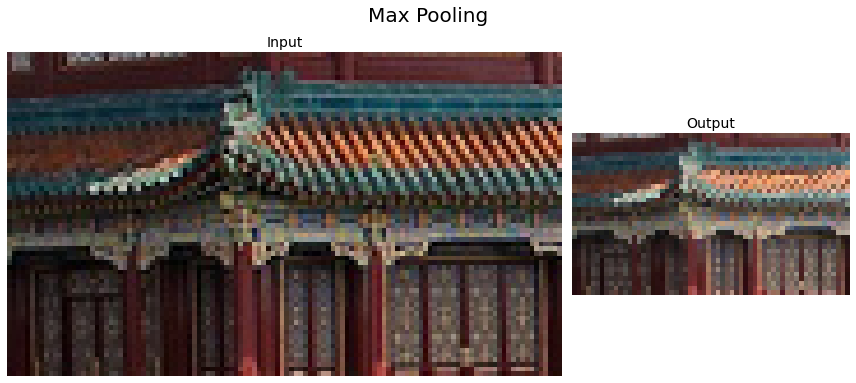

In [17]:
fig = plt.figure(figsize=(12, 6))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
save_fig("china_max_pooling")
plt.suptitle('Max Pooling', size=20)
plt.show()

### Depth-wise Pooling

In [18]:
with tf.device('/cpu:0'):
    output = tf.nn.max_pool(
        images,
        ksize=(1, 1, 1, 3),
        strides=(1, 1, 1, 3),
        padding='VALID'
    )

If you want to include this as a layer in your Keras models, wrap it
in a Lambda layer (or create a custom Keras layer):

In [19]:
depth_pool = keras.layers.Lambda(
    lambda X: tf.nn.max_pool(
            X,
            ksize=(1, 1, 1, 3),
            strides=(1, 1, 1, 3),
            padding='VALID'
        )
)

In [20]:
# Custom Keras Layer for depth-wise pooling
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding='VALID', **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(
            inputs,
            ksize=(1, 1, 1, self.pool_size),
            strides=(1, 1, 1, self.pool_size),
            padding=self.padding
        )

In [21]:
depth_pool = DepthMaxPool(3)
with tf.device('/cpu:0'):  # There is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

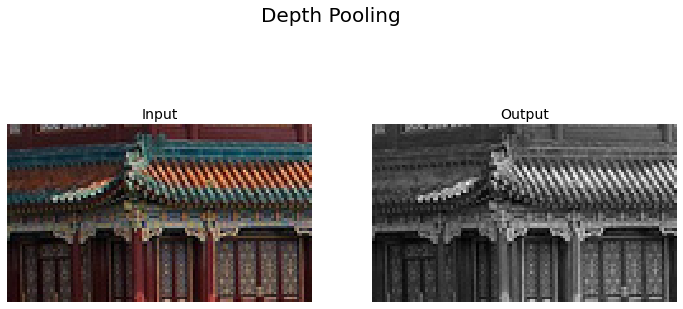

In [22]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])  # plot the 1st image
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])  # plot the output for the 1st image
plt.axis("off")
plt.suptitle('Depth Pooling', size=20)
plt.show()

### Average Pooling

In [23]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)
output_avg = avg_pool(cropped_images)

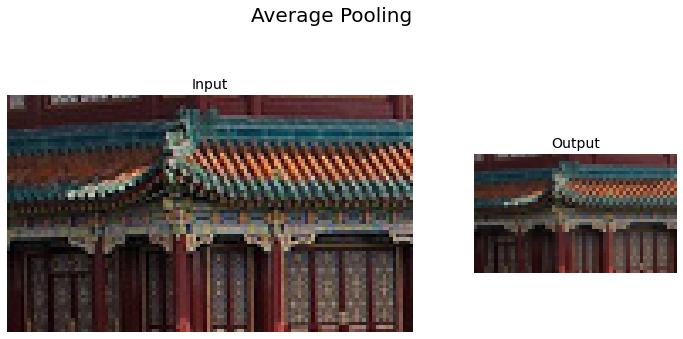

In [24]:
fig = plt.figure(figsize=(12, 6))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # plot the output for the 1st image
ax2.axis("off")
plt.suptitle('Average Pooling', size=20)
plt.show()

### Global Average Pooling
One last type of pooling layer that you will often see in modern
architectures is the global average pooling layer. It works very
differently: all it does is compute the mean of each entire feature
map (it’s like an average pooling layer using a pooling kernel with
the same spatial dimensions as the inputs). This means that it just
outputs a single number per feature map and per instance. Although
this is of course extremely destructive (most of the information in
the feature map is lost), it can be useful as the output layer, as we
will see later in this chapter. To create such a layer, simply use the
keras.layers.GlobalAvgPool2D class:

In [25]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788777 , 0.22507192, 0.20967275],
       [0.51288515, 0.45951638, 0.33423486]], dtype=float32)>

It’s equivalent to this simple Lambda layer, which computes the mean
over the spatial dimensions (height and width):

In [26]:
output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
output_global_avg2(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788777 , 0.22507192, 0.20967275],
       [0.51288515, 0.45951638, 0.33423486]], dtype=float32)>

## CNN Architectures
<a href='https://keras.io/api/applications/'>Keras Pretrained Models</a>

### Tackling Fashion MNIST with a CNN

In [27]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

4431872/4422102 [==============================] - 0s 0us/step


Partial functions allow us to fix a certain number of arguments of a function and generate a new function.

In [28]:
from functools import partial
  
# A normal function
def f(a, b, c, x):
    return 1000*a + 100*b + 10*c + x
  
# A partial function that calls f with
# a as 3, b as 1 and c as 4.
g = partial(f, 3, 1, 4)
  
# Calling g()
print(g(5))

3145


In the example we have pre-filled our function with some constant values of a, b and c. And g() just takes a single argument i.e. the variable x.

In [29]:
DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

In [30]:
model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 64)        3200      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 256)         5

In [32]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='nadam',
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    y_train,
    epochs=10,
    validation_data=(X_valid, y_valid)
)

score = model.evaluate(X_test, y_test)

Epoch 1/10
1719/1719 [==============================] - 39s 21ms/step - loss: 0.7163 - accuracy: 0.7491 - val_loss: 0.3982 - val_accuracy: 0.8602
Epoch 2/10
1719/1719 [==============================] - 35s 20ms/step - loss: 0.4291 - accuracy: 0.8558 - val_loss: 0.3616 - val_accuracy: 0.8718
Epoch 3/10
1719/1719 [==============================] - 35s 20ms/step - loss: 0.3749 - accuracy: 0.8750 - val_loss: 0.3237 - val_accuracy: 0.8818
Epoch 4/10
1719/1719 [==============================] - 35s 20ms/step - loss: 0.3414 - accuracy: 0.8861 - val_loss: 0.2941 - val_accuracy: 0.8908
Epoch 5/10
1719/1719 [==============================] - 35s 20ms/step - loss: 0.3138 - accuracy: 0.8928 - val_loss: 0.3077 - val_accuracy: 0.8872
Epoch 6/10
1719/1719 [==============================] - 35s 20ms/step - loss: 0.2938 - accuracy: 0.9007 - val_loss: 0.3018 - val_accuracy: 0.8866
Epoch 7/10
1719/1719 [==============================] - 35s 20ms/step - loss: 0.2824 - accuracy: 0.9058 - val_loss: 0.2892 -

In [33]:
X_new = X_test[:10]
y_pred = model.predict(X_new)

### LeNet-5
The LeNet-5 architecture is perhaps the most widely known CNN
architecture. As mentioned earlier, it was created by Yann LeCun in
1998 and has been widely used for handwritten digit recognition
(MNIST).


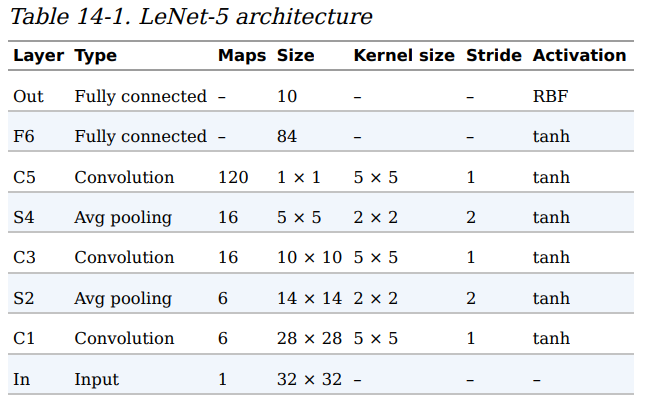

In [34]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")
X_train, X_valid = X_train_full[:50000], X_train_full[50000:]
y_train, y_valid = y_train_full[:50000], y_train_full[50000:]
#Reshape the training and test set
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_valid = X_valid.reshape(X_valid.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
#Padding the images by 2 pixels since in the paper input images were 32x32
X_train = np.pad(X_train, ((0, 0), (2,2), (2,2), (0, 0)), 'edge')
X_valid = np.pad(X_valid, ((0, 0), (2,2), (2,2), (0, 0)), 'edge')
X_test = np.pad(X_test, ((0, 0), (2,2),(2,2), (0, 0)), 'edge')

11501568/11490434 [==============================] - 0s 0us/step


In [35]:
X_train.shape

(50000, 32, 32, 1)

In [36]:
from keras.utils.np_utils import to_categorical

In [37]:
# One-hot encoding label 
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)
y_test = to_categorical(y_test)

In [38]:
model = keras.models.Sequential([
    keras.layers.Dense(1, input_shape=(32, 32, 1)),
    keras.layers.Conv2D(filters=6, kernel_size=(5, 5), strides=1, activation='relu', input_shape=(28, 28, 1)),
    keras.layers.AvgPool2D(pool_size=(2, 2), strides=2),
    keras.layers.Conv2D(filters=16, kernel_size=(5, 5), strides=1, activation='relu'),
    keras.layers.AvgPool2D(pool_size=(2, 2), strides=2),
    keras.layers.Conv2D(filters=120, kernel_size=(5, 5), strides=1, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(84, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [39]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [40]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,
                                        restore_best_weights=True)
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping_cb]
)

Epoch 1/50
1563/1563 [==============================] - 12s 7ms/step - loss: 0.1400 - accuracy: 0.9580 - val_loss: 0.0555 - val_accuracy: 0.9833
Epoch 2/50
1563/1563 [==============================] - 10s 7ms/step - loss: 0.0550 - accuracy: 0.9827 - val_loss: 0.0644 - val_accuracy: 0.9816
Epoch 3/50
1563/1563 [==============================] - 10s 7ms/step - loss: 0.0406 - accuracy: 0.9871 - val_loss: 0.0490 - val_accuracy: 0.9862
Epoch 4/50
1563/1563 [==============================] - 10s 7ms/step - loss: 0.0321 - accuracy: 0.9897 - val_loss: 0.0456 - val_accuracy: 0.9879
Epoch 5/50
1563/1563 [==============================] - 10s 7ms/step - loss: 0.0265 - accuracy: 0.9914 - val_loss: 0.0479 - val_accuracy: 0.9856
Epoch 6/50
1563/1563 [==============================] - 10s 7ms/step - loss: 0.0234 - accuracy: 0.9923 - val_loss: 0.0402 - val_accuracy: 0.9882
Epoch 7/50
1563/1563 [==============================] - 10s 7ms/step - loss: 0.0173 - accuracy: 0.9941 - val_loss: 0.0355 - val_ac

### AlexNet


In [50]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers import BatchNormalization
from keras.regularizers import l2
from tensorflow.nn import local_response_normalization

In [51]:
alexnet_regularizer = keras.layers.Lambda(lambda X: local_response_normalization(
                                                    X,
                                                    depth_radius=2,
                                                    bias=1,
                                                    alpha=0.00002,
                                                    beta=0.75
))

In [55]:
# Initialize model
alexnet = Sequential()

# Layer 1
alexnet.add(Conv2D(
    filters=96,
    kernel_size=(11, 11),
    input_shape=(224, 224, 3),
    strides=4,
    padding='valid',
    kernel_regularizer=alexnet_regularizer
))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))
alexnet.add(MaxPooling2D(pool_size=(2, 2), strides=2))

# Layer 2
alexnet.add(Conv2D(
    filters=256,
    kernel_size=(5, 5),
    strides=1,
    padding='same',
    kernel_regularizer=alexnet_regularizer
))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))
alexnet.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))

# Layer 3
alexnet.add(ZeroPadding2D((1, 1)))
alexnet.add(Conv2D(
    filters=384,
    kernel_size=(3, 3),
    strides=1,
    padding='same'
))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))

# Layer 4
alexnet.add(ZeroPadding2D((1, 1)))
alexnet.add(Conv2D(
    filters=384,
    kernel_size=(3, 3),
    strides=1,
    padding='same'
))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))

# Layer 5
alexnet.add(ZeroPadding2D((1, 1)))
alexnet.add(Conv2D(
    filters=256,
    kernel_size=(3, 3),
    strides=1,
    padding='same'
))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))

# Layer 6
alexnet.add(Flatten())
alexnet.add(Dense(4096))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))
alexnet.add(Dropout(0.5))

# Layer 7
alexnet.add(Dense(4096))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))
alexnet.add(Dropout(0.5))

# Layer 8
alexnet.add(Dense(10))
alexnet.add(BatchNormalization())
alexnet.add(Activation('softmax'))